In [1]:
import pandas as pd

In [2]:
ecapa_results = '../data/lid-vox-lingua107-ecapa-results'

In [10]:
df = pd.read_csv(ecapa_results+'.csv')
df.head()

,label,pred,pred_score,eng_score,acc
0,tic,sl,0.2963,0.0002,1
1,tic,no,0.2148,0.0166,1
2,tic,sw,0.2069,0.0011,1
3,tic,so,0.3580,0.0045,1
4,tic,sl,0.3263,0.0001,1


In [15]:
tic = df['label']=='tic'
eng = df['label']=='eng'

<Axes: title={'center': 'eng_score'}, xlabel='label'>

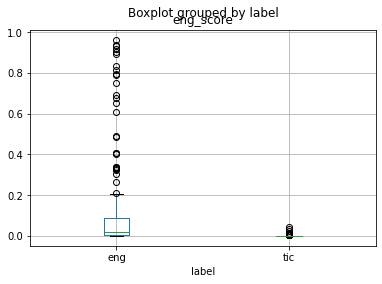

In [14]:
df.boxplot('eng_score', by='label')

In [18]:
eng_thresh = df.loc[tic, 'eng_score'].max()
eng_thresh

0.0433

In [24]:
eng_thresh = 0.01

In [25]:
above_thresh = df['eng_score'] > eng_thresh
df.loc[above_thresh, 'label'].value_counts()

eng    131
tic      7
Name: label, dtype: int64

In [26]:
df.loc[~above_thresh, 'label'].value_counts()

tic    193
eng     69
Name: label, dtype: int64

In [22]:
from sklearn.decomposition import PCA
import torch
from matplotlib import pyplot as plt
import pandas as pd

In [24]:
df = pd.read_csv('../data/lid-vox-lingua107-ecapa-embeds-3cat.csv')
df.head()

,Unnamed: 0,lang,audio
0,0,TIC,HH01082021[1848109.0-1852185.0].wav
1,1,TIC,HH01082021[2079480.0-2081330.0].wav
2,2,TIC,HH01082021[2321430.0-2322660.0].wav
3,3,TIC,HH01082021[693460.0-695680.0].wav
4,4,TIC,HH01222021[1106693.0-1109490.0].wav


In [11]:
embeds = torch.load('../data/lid-vox-lingua107-ecapa-embeds.pt', map_location=torch.device('cpu'))
embeds = embeds.squeeze()
embeds.shape

torch.Size([400, 256])

In [7]:
pca = PCA(n_components=2)
pca

PCA(n_components=2)

In [14]:
pca_embeds = pca.fit_transform(embeds)
pca_embeds

array([[-8.44432073e+01, -5.16140729e+01],
       [-1.77554235e+01,  2.06572027e+01],
       [ 9.78664931e+00,  3.28834133e+01],
       [-3.56801409e+01, -6.31210925e+01],
       [-9.22758212e+01,  2.28551140e+01],
       [-1.01255678e+02,  2.11101431e+01],
       [-1.05036660e+02, -1.37479462e+01],
       [-8.30470430e+01,  2.74775739e+01],
       [-7.29714858e+01,  1.90469202e+01],
       [-1.01593240e+02,  1.18933797e+01],
       [-9.12411942e+01,  1.66989723e+01],
       [-7.19453023e+01, -6.31691713e+00],
       [ 1.68128747e+01,  5.80965363e+01],
       [-9.55919869e+01, -2.50940307e+01],
       [-6.68176268e+01, -1.08524143e+01],
       [-9.53275742e+01,  5.09394478e+01],
       [-7.68486306e+01, -1.48258795e+01],
       [-2.30659532e+01,  4.85552013e+01],
       [-4.60945558e+01,  6.71538837e+01],
       [-2.06757618e+01,  6.52777615e+01],
       [-2.92950922e+01,  1.10227961e+01],
       [ 2.91712424e+01,  4.91641203e+00],
       [ 9.86777502e+01,  6.61526647e+01],
       [ 2.

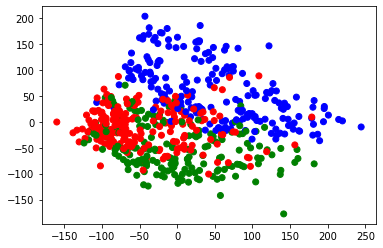

In [34]:
df['color'] = 'blue'
df.loc[df['lang']=='TIC','color'] = 'red'
df.loc[df['lang']=='HIM','color'] = 'green'

x = pca_embeds[:,0]
y = pca_embeds[:,1]
c = df['color']
plt.scatter(x, y, c=c)